# Assignment 4

**Assignment 4: Neural Networks**

**Goal**: ​Get familiar with neural networks by implementing them and applying them to image classification.

In this assignment we are going to learn about neural networks (NNs). The goal is to implement two neural networks: a fully-connected neural network, a convolutional neural network, and analyze their behavior.

The considered task is image classification. We consider a dataset of small natural images (see the additional file) with multiple classes. We aim at formulating a model (a neural network) and learning it using the negative log-likelihood function (i.e., the cross-entropy loss) as the objective function, and the stochastic gradient descent as the optimizer.

In this assignment, ​**the code must be implemented in PyTorch**.

## 1 Understanding the problem



The considered problem is about classifying images to $L$ classes. In the first part of the assignment, you are asked get familiar with PyTorch, a deep learning library, and the basics of neural networks, and implement neural-network-based classifiers. For this purpose, we will start with classifying small images (8px x 8px) of handwritten digits to one of 10 classes. The dataset is very small and all experiments could be achieved within a couple of minutes.

In the second part, you are asked to implement the whole pipeline for a given dataset by yourself.

Please run the code below and spend a while on analyzing the images.

If any code line is unclear to you, please read on that in numpy, scipy, matplotlib and PyTorch docs.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn import datasets
from sklearn.datasets import load_digits
from torch.utils.data import DataLoader, Dataset

EPS = 1.0e-7

In [ ]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# IF YOU USE COLAB, THIS IS VERY USEFUL! OTHERWISE, PLEASE REMOVE IT.
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
#results_dir = "/content/gdrive/My_Drive/Colab Notebooks/TEACHING/"

results_dir = "/content/gdrive/MyDrive/CI"

In [ ]:
# PLEASE DO NOT REMOVE!
# This is a class for the dataset of small (8px x 8px) digits.
# Please try to understand in details how it works!
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode="train", transforms=None):
        digits = load_digits()
        if mode == "train":
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == "val":
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

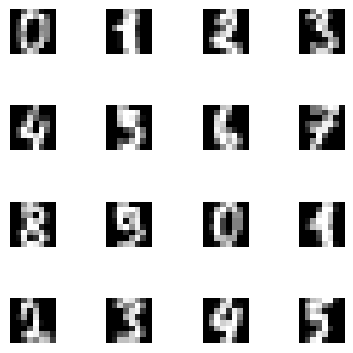

In [ ]:
# PLEASE DO NOT REMOVE
# Here, we plot some images (8px x 8px).
digits = load_digits()
x = digits.data[:16].astype(np.float32)

fig_data, axs = plt.subplots(4, 4, figsize=(4, 4))
fig_data.tight_layout()

for i in range(4):
    for j in range(4):
        img = np.reshape(x[4 * i + j], (8, 8))
        axs[i, j].imshow(img, cmap="gray")
        axs[i, j].axis("off")

## 2 Neural Networks for Digits (4pt)

In this assignment, you are asked to implement a neural network (NN) classifier. Please take a look at the class below and fill in the missing parts.

NOTE: Please pay attention to the inputs and outputs of each function.

### 2.1 Neural Network Classifier

Below, we have two helper modules (layers) that can be used to reshape and flatten a tensor. They are useful for creating sequentials with convolutional layers.

In [ ]:
# PLEASE DO NOT REMOVE!
# Here are two auxiliary functions that can be used for a convolutional NN (CNN).


# This module reshapes an input (matrix -> tensor).
class Reshape(nn.Module):
    def __init__(self, size):
        super(Reshape, self).__init__()
        self.size = size  # a list

    def forward(self, x):
        assert x.shape[1] == np.prod(self.size)
        return x.view(x.shape[0], *self.size)


# This module flattens an input (tensor -> matrix) by blending dimensions
# beyond the batch size.
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.shape[0], -1)

Below is the main class for a classifier parameterized by a neural network.

In [ ]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but it is explained badly
# 1.0 pt if code works and it is explained well
# =========
# Implement a neural network (NN) classifier.
class ClassifierNeuralNet(nn.Module):
    def __init__(self, classnet):
        super(ClassifierNeuralNet, self).__init__()
        # We provide a sequential module with layers and activations
        self.classnet = classnet
        # The loss function (the negative log-likelihood)
        self.nll = nn.NLLLoss(reduction="none")  # it requires log-softmax as input!!

    # This function classifies an image x to a class.
    # The output must be a class label (long).
    def classify(self, x):
        # ------
        # PLEASE FILL IN
        # calculate scores of given classnet
        scores = self.classnet(x)
        # predict the label based on highest score
        y_pred = scores.argmax(dim=1)
        # cast to long
        y_pred = y_pred.long()
        return y_pred

    # This function is crucial for a module in PyTorch.
    # In our framework, this class outputs a value of the loss function.
    def forward(self, x, y, reduction="avg"):
        # ------
        # PLEASE FILL IN
        # nll between log-softmax result and the target
        loss = self.nll(self.classnet(x), y)
        # return the loss based on reduction
        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

**Question 1 (0-0.5pt):** What is the objective function for a classification task? In other words, what is nn.NLLLoss in the code above? Pelase write it in mathematical terms.

**Answer:**


A objective function for a classification task in general is the function that we want to 'optimize' in this case minimize its value. NLLLoss = negative log likelihood loss. It meaures the 'difference' between the predicted value and the actual value. Difference here depends on the loss function, for NLLLoss it can be described as the negative log likelihood of the predicted probability distribution of the class label. It is used for classification problems. More specifically, it can also be used in multiclass classifications.

Negative Log Likelihood:

$$ \mathcal{L}(\theta) = - \sum_{i=1}^{n} \log p(y_i | x_i; \theta) $$
 

where $p(y_i | x_i; \theta)$ is the probability of the correct class $y_i$ given the input $x_i$ and parameterized by $\theta$.


Also we can write it as:
Let $y$ be the true label and $y_hat$ be the predicted label. Then the negative log likelihood loss is:


More details on the specifics of torch.nn.NLLLoss can be found here: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html


**Question 2 (0-0.5pt):** In the code above, it is said to use the logarithm of the softmax as the final activation function. Is it correct to use the log-softmax instead of the softmax for making predictions (i.e., picking the most probable label).

**Answer:** 

Yes it is correct to use the log-softmax instead of the softmax for making predictions. The log-softmax is just takes the logarithm of the softmax result. this would make the results squeeze into a smaller range. Thus it does not effect ordering of the class probabilities or selection. 

### 2.2 Evaluation

In [ ]:
# PLEASE DO NOT REMOVE
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error


# An auxiliary function for plotting the performance curves
def plot_curve(
    name,
    signal,
    file_name="curve.pdf",
    xlabel="epochs",
    ylabel="nll",
    color="b-",
    test_eval=None,
):
    # plot the curve
    plt.plot(
        np.arange(len(signal)), signal, color, linewidth="3", label=ylabel + " val"
    )
    # if available, add the final (test) performance
    if test_eval is not None:
        plt.hlines(
            test_eval,
            xmin=0,
            xmax=len(signal),
            linestyles="dashed",
            label=ylabel + " test",
        )
        plt.text(
            len(signal),
            test_eval,
            "{:.3f}".format(test_eval),
        )
    # set x- and ylabels, add legend, save the figure
    plt.xlabel(xlabel), plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name + file_name, bbox_inches="tight")
    plt.show()

### 2.3 Training procedure

In [ ]:
# PLEASE DO NOT REMOVE!
# The training procedure
def training(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val

### 2.4 Experiments

#### Initialize dataloaders

In [ ]:
# PLEASE DO NOT REMOVE
# Initialize training, validation and test sets.
train_data = Digits(mode="train")
val_data = Digits(mode="val")
test_data = Digits(mode="test")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
print("How do we get our data from Digits class? \n")
print(f"Feature example: {train_data[1][0]}")
print(f"Feature example shape: {train_data[1][0].shape}")
print(f"Label example: {train_data[1][1]}")

How do we get our data from Digits class? 

Feature example: [ 0.  0.  0. 12. 13.  5.  0.  0.  0.  0.  0. 11. 16.  9.  0.  0.  0.  0.
  3. 15. 16.  6.  0.  0.  0.  7. 15. 16. 16.  2.  0.  0.  0.  0.  1. 16.
 16.  3.  0.  0.  0.  0.  1. 16. 16.  6.  0.  0.  0.  0.  1. 16. 16.  6.
  0.  0.  0.  0.  0. 11. 16. 10.  0.  0.]
Feature example shape: (64,)
Label example: 1


In [ ]:
print("How do we get our data from Pytorch DataLoader class? \n")
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

print("\n\nWhat happens if we reshape a feature batch? \n")
reshape = Reshape(size=(1, 8, 8))
train_features_reshaped = reshape(train_features)
print(f"Feature batch shape after reshape: {train_features_reshaped.size()}")

print("\n\nWhat happens if we flatten a reshaped feature batch? \n")
flatten = Flatten()
train_features_flattened = flatten(train_features_reshaped)
print(f"Feature batch shape after flatten: {train_features_flattened.size()}")

How do we get our data from Pytorch DataLoader class? 

Feature batch shape: torch.Size([64, 64])
Labels batch shape: torch.Size([64])


What happens if we reshape a feature batch? 

Feature batch shape after reshape: torch.Size([64, 1, 8, 8])


What happens if we flatten a reshaped feature batch? 

Feature batch shape after flatten: torch.Size([64, 64])


#### Initialize hyperparameters

In [ ]:
# PLEASE DO NOT REMOVE
# Hyperparameters
# -> data hyperparams
D = 64  # input dimension

# -> model hyperparams
M = 256  # the number of neurons in scale (s) and translation (t) nets
K = 10  # the number of labels
num_kernels = 32  # the number of kernels for CNN

# -> training hyperparams
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

#### Running experiments

In the code below, you are supposed to implement architectures for MLP and CNN. For properly implementing these architectures, you can get 0.5pt for each of them.


-> START classifier_mlp
Epoch: 0, val nll=1.3158433205740792, val ce=0.4342857142857143
Epoch: 10, val nll=0.17453345843723841, val ce=0.037142857142857144
Epoch: 20, val nll=0.1254271922792707, val ce=0.02857142857142857
Epoch: 30, val nll=0.1093378792490278, val ce=0.025714285714285714
Epoch: 40, val nll=0.09784524304526193, val ce=0.022857142857142857
Epoch: 50, val nll=0.09244576658521379, val ce=0.022857142857142857
Epoch: 60, val nll=0.09155432888439724, val ce=0.025714285714285714
Epoch: 70, val nll=0.08902663605553764, val ce=0.02857142857142857
Epoch: 80, val nll=0.090723899773189, val ce=0.02857142857142857
Epoch: 90, val nll=0.08877648515360696, val ce=0.025714285714285714
-> FINAL PERFORMANCE: nll=0.30091190551484726, ce=0.07606263982102908


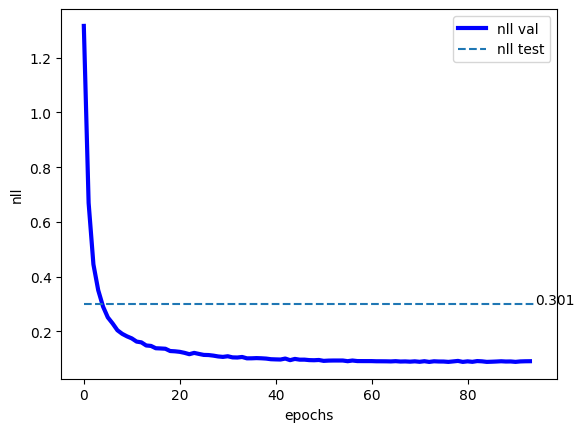

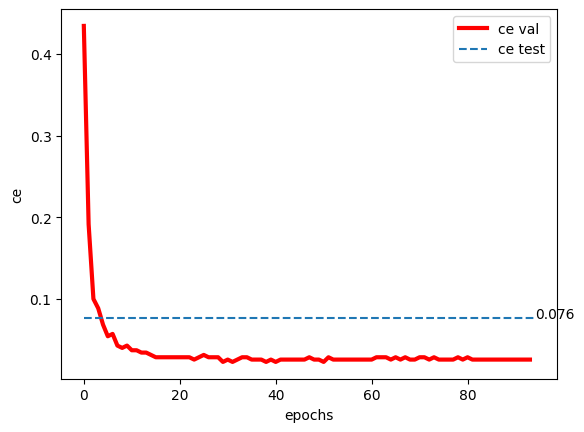


-> START classifier_cnn
Epoch: 0, val nll=1.662102552141462, val ce=0.22857142857142856
Epoch: 10, val nll=0.135828138760158, val ce=0.02857142857142857
Epoch: 20, val nll=0.07664714302335467, val ce=0.017142857142857144
Epoch: 30, val nll=0.0647085064649582, val ce=0.017142857142857144
Epoch: 40, val nll=0.06923112609556743, val ce=0.017142857142857144
Epoch: 50, val nll=0.06577548393181393, val ce=0.017142857142857144
-> FINAL PERFORMANCE: nll=0.20681284151354626, ce=0.053691275167785234


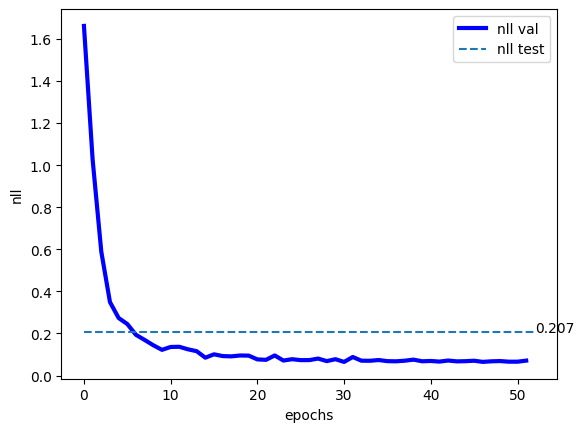

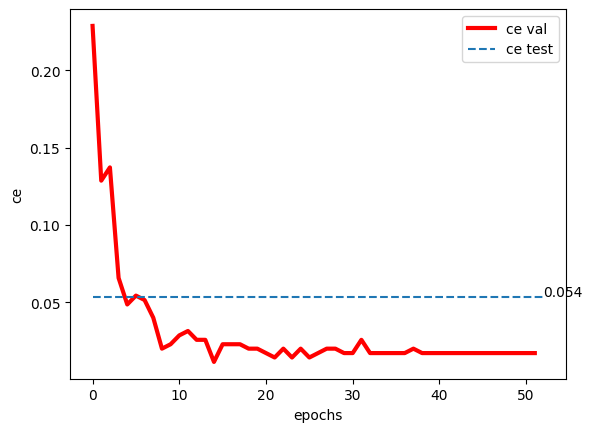

In [ ]:
# PLEASE DO NOT REMOVE and FILL IN WHEN NECESSARY!
from collections import OrderedDict
# We will run two models: MLP and CNN
names = ["classifier_mlp", "classifier_cnn"]

# loop over models
for name in names:
    print("\n-> START {}".format(name))
    # Create a folder (REMEMBER: You must mount your drive if you use Colab!)
    if name == "classifier_mlp":
        name = name + "_M_" + str(M)
    elif name == "classifier_cnn":
        name = name + "_M_" + str(M) + "_kernels_" + str(num_kernels)

    # Create a folder if necessary
    result_dir = os.path.join(results_dir, "results", name + "/")

    # =========
    # MAKE SURE THAT "result_dir" IS A PATH TO A LOCAL FOLDER OR A GOOGLE COLAB FOLDER (DEFINED IN CELL 3)
    result_dir = "./"  # (current folder)
    # =========
    if not (os.path.exists(result_dir)):
        os.mkdir(result_dir)

    # MLP
    if name[0:14] == "classifier_mlp":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        # classnet = nn.Sequential(...)
        #
        # You are asked here to propose your own architecture
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        classnet = nn.Sequential(OrderedDict([
            # Reshape the input to a vector 
            ('reshape', Reshape(size=(1, 8, 8))),
            # Flatten the vector 
            ('flatten', Flatten()),
            # Linear layer that has D input and M output neurons
            ('linear1', nn.Linear(D, M)),
            # Leaky ReLU activation for non-linearity
            ('leakyrelu1', nn.LeakyReLU()),
            # Linear layer that has M input and M output neurons
            ('linear2', nn.Linear(M, M)),  
            # logsoftmax activation as a last layer      
            ('logsoftmax', nn.LogSoftmax(dim=1))

        ]))
        

    # CNN
    elif name[0:14] == "classifier_cnn":
        # =========
        # GRADING:
        # 0
        # 0.5pt if properly implemented
        # =========
        # ------
        # PLEASE FILL IN:
        # classnet = nn.Sequential(...)
        #
        # You are asked here to propose your own architecture
        # NOTE: Plese note that the images are represented as vectors, thus, you must
        # use Reshape(size) as the first layer, and Flatten() after all convolutional
        # layers and before linear layers.
        # NOTE: Please remember that the output must be LogSoftmax!
        # ------
        # It has the following structure:
        # conv - leakyrelu - 2x2 max pool - conv - leaky relu - 2x2 max pool - fc layer - leaky relu- fc layer- logsoftmax
        classnet = nn.Sequential(OrderedDict([
            # Reshape the input to a vector
            ('reshape', Reshape(size=(1, 8, 8))),
            # 1st convolutional layer 
            ('conv1', nn.Conv2d(1, num_kernels, kernel_size=3, stride=1, padding=1)),
            # LeakyReLU activation
            ('leakyrelu1', nn.LeakyReLU()),
            # MaxPool for downsampling
            ('maxpool1', nn.MaxPool2d(kernel_size=2, stride=2)),
            # 2nd convolutional layer
            ('conv2', nn.Conv2d(num_kernels, num_kernels, kernel_size=3, stride=1, padding=1)),
            # LeakyReLU activation
            ('leakyrelu2', nn.LeakyReLU()),
            # MaxPool for downsampling
            ('maxpool2', nn.MaxPool2d(kernel_size=2, stride=2)),
            # Flatten before fully connected layers
            ('flatten', Flatten()),
            # 1st fully connected layer 128 calculated to fit with input of the prior layer
            ('linear1', nn.Linear(128, M)),
            # LeakyReLU activation
            ('leakyrelu3', nn.LeakyReLU()),
            # 2nd fully connected layer
            ('linear2', nn.Linear(M, K)),
            # LogSoftmax activation
            ('logsoftmax', nn.LogSoftmax(dim=1))

        ]))


    # Init ClassifierNN
    model = ClassifierNeuralNet(classnet)

    # Init OPTIMIZER (here we use ADAMAX)
    optimizer = torch.optim.Adamax(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=lr,
        weight_decay=wd,
    )

    # Training procedure
    nll_val, error_val = training(
        name=result_dir + name,
        max_patience=max_patience,
        num_epochs=num_epochs,
        model=model,
        optimizer=optimizer,
        training_loader=training_loader,
        val_loader=val_loader,
    )

    # The final evaluation (on the test set)
    test_loss, test_error = evaluation(name=result_dir + name, test_loader=test_loader)
    # write the results to a file
    f = open(result_dir + name + "_test_loss.txt", "w")
    f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
    f.close()
    # create curves
    plot_curve(
        result_dir + name,
        nll_val,
        file_name="_nll_val_curve.pdf",
        ylabel="nll",
        test_eval=test_loss,
    )
    plot_curve(
        result_dir + name,
        error_val,
        file_name="_ca_val_curve.pdf",
        ylabel="ce",
        color="r-",
        test_eval=test_error,
    )

## 2.5 Analysis

**Question 3 (0-0.5pt)**: Please compare the convergence of MLP and CNN in terms of the loss function and the classification error.

**Answer**: 

**1. Loss Function:**

We can observe from the plot below that loss function achieves a lower value for the CNN than for the MLP. This indicates that CNN is better to detect probabilities compared to MLP. 

Both were able to generate less than 0.2 on validation data (for MLP best result is generated on validation data on 90th epoch with val nll=0.08877648515360696 whereas for CNN and on validation data it was on 30th epoch with val nll=0.0647085064649582). However on the test data loss for MLP is 0.3 whereas it is 0.2 on CNN. 

Moreover, CNN took less iterations to terminated due to early stopping. This might be because it was faster to convergence and then it maybe started to overfit so that validation did not improve anymore. Overall we can say that CNN converged faster (not in terms of total time but in terms of iterations) and achieved a better result in the loss function on test data so it 'optimized' better on the objective function and better to generalize. 


<img src="output_mlp_loss.png" title="MLP" width="400"/>
<img src="output_cnn_loss.png" title="CNN" width="400"/>

**2. Classification Error:**

Pretty much same analysis can be done on the classification error as well. We can observe from the plot below that classification error achieves a lower value for the CNN than for the MLP. This indicates that CNN is better to predict correct class compared to MLP. 

Again both were able to generate error that is less than 0.025 on validation data (mlp: 0.22 epoch 40 | cnn: 0.017 epoch 30). However on the test data error for MLP is 0.076 whereas it is 0.054 on CNN.

Reasoning on the total number of epoch before cutting out by early stopping is the same as above. Overall we can say that CNN converged faster (not in terms of total time but in terms of iterations) and achieved a better result in the classification error on test data so it 'optimized' better on the objective function and better to generalize.

<img src="output_mlp_error.png"  title="MLP" width="400"/>
<img src="output_cnn_error.png" title="CNN" width="400"/>



**Question 4 (0-0.5pt)**: In general, for a properly picked architectures, a CNN should work better than an MLP. Did you notice that? Why (in general) CNNs are better suited to images than MLPs?

**Answer**: 
Yes I noticed that both from our experiment and the fact that CNNs are widely used in CV tasks compared to MLP.

MLP basically consists of many linear layers and nonlinearity functions whereas CNN consist of convulation layers. 

Convulational layers help us to capture the spatial information of the image. Model can learn relationship between of some pixel and its neighbours. However, in the linear layers of MLP, image is only regarded as a flattened vector. Thus, MLPs are not able to capture the spatial information of the image that pixels are related to each other. 

Moreover MLPs have more parameters than CNNs. This is because in each layer of MLP, we have a weight matrix that is multiplied by the input vector. However, in CNNs, we have a kernel that is multiplied by the input image. Since the kernel is convolved around the image with certain size, padding and stride, it basically can downsample the image (reduce size). At the end we have less parameters in CNNs. Thus, they are more easier to train and optimize both in terms of time and memory complexity. 

## 3 Application to Street House View Numbers (SVHN) (6pt)

Please repeat (some) of the code in the previous section and apply a bigger convolutional neural network (CNN) to the following dataset:

http://ufldl.stanford.edu/housenumbers/

Please follow the following steps:
1. (1pt) Create appropriate Dataset class. Please remember to use the original training data and test data, and also to create a validation set from the traning data (at least 10% of the training examples). **Do not use extra examples!**
2. (1pt) Implement an architecture that will give at most 0.1 classification error. For instance, see this paper as a reference: https://arxiv.org/pdf/1204.3968.pdf#:~:text=The%20SVHN%20classification%20dataset%20%5B8,set%20of%20more%20difficult%20samples
3. (1pt) Think of an extra component that could improve the performance (e.g., a regularization, specific activation functions).
4. (1pt) Provide a good explanation of the applied architecture and a description of all components.
5. (2pt) Analyze the results.

**Please be very precise, comment your code and provide a comprehensive and clear analysis.**

### 3.1 Dataset

In [ ]:
from torchvision.datasets import SVHN
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split

# svhn dataset from torchvision is used for effective data download
SVHN(root =  "/content/gdrive/MyDrive/CI" ,split='test', download=True)
SVHN(root =  "/content/gdrive/MyDrive/CI" ,split='train', download=True)


Using downloaded and verified file: /content/gdrive/MyDrive/CI/test_32x32.mat
Using downloaded and verified file: /content/gdrive/MyDrive/CI/train_32x32.mat


Dataset SVHN
    Number of datapoints: 73257
    Root location: /content/gdrive/MyDrive/CI
    Split: train

In [ ]:

class HouseNumbers(Dataset):
    """House Numbers Dataset."""

    def __init__(self, root = './', mode="train", transform=None, val_ratio=0.2):
        """
        Dataset Class for House Numbers Dataset. 
        It uses SVHN dataset from torchvision to download the dataset but only uses the train and test splits.
        It creates its own data and target variables by splitting the train set into train and validation sets. 
        So that it can be used in a standard way for training, validation, and test purposes with PyTorch DataLoader.
        Args:
            root (string): Directory with all the images (default: './')
            mode (string): train, val, or test (default: train)
            transforms (function): Optional transform to be applied on a sample.
            val_ratio (float): Ratio of validation set when mode is train (default: 0.2)
        """
        self.transform = transform
        self.mode = mode
        self.val_ratio = val_ratio
        self.root = root

        if self.mode == 'test':
            # load test set
            test_set = SVHN(root=self.root, split='test', transform=transforms.ToTensor())
            # set data and target variables
            self.data = test_set.data
            self.target = test_set.labels
        else:
            # decide train and validation indices 
            # set random seed to 0 for achieving the same result in each instance of the class
            train_indices, val_indices = train_test_split(
                                            np.arange(len(SVHN(root=self.root, split='train'))), 
                                            test_size=self.val_ratio, 
                                            random_state=0)
            # if mode is train, load train set
            if self.mode == 'train':
                complete = SVHN(root=self.root, split='train', transform=transforms.ToTensor())
                self.data = torch.utils.data.Subset(complete.data, train_indices)
                self.target = np.array(complete.labels)[train_indices]
            # if mode is val, load validation set
            elif self.mode == 'val':
                complete = SVHN(root=self.root, split='train', transform=transforms.ToTensor())
                self.data = torch.utils.data.Subset(complete.data, val_indices)
                self.target = np.array(complete.labels)[val_indices]
            else :
                raise ValueError('Invalid mode %s' % self.mode)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.target[idx]
        if self.transform:
            sample_x = self.transform(sample_x)
        return (sample_x, sample_y)        

In [ ]:
# Initialize training, validation and test sets.
train_data = HouseNumbers(mode="train", root= "/content/gdrive/MyDrive/CI")
val_data = HouseNumbers(mode="val",  root= "/content/gdrive/MyDrive/CI")
test_data = HouseNumbers(mode="test",  root= "/content/gdrive/MyDrive/CI")

# Initialize data loaders.
training_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
# move dataloaders to device as well
# otherwise the training process will give an error
# model parameters will be on the device and have type torch.cuda.FloatTensor
# but the data will be on the CPU and have type torch.FloatTensor 
# so we need to move the data to the device that the model is on to make sure they are the same type
# to fix this issue, found following solution in the pytorch documentation 
# modified it to fit our needs
# ref: https://pytorch.org/tutorials/beginner/nn_tutorial.html#wrapping-dataloader
class WrappedDataLoaderCustomize():
    def __init__(self, dl, device):
        self.dl = dl
        # in the original code, there is a function 
        # but here it will be fixed: 'to_device' so not included
        self.device = device

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        for i in self.dl:
            yield self.move_to_device(i, self.device)
    
    def move_to_device(self, b, device):
        # since the our data can be tuple shaped, we need to move each element to the device recursively
        # check the input type
        # move each element to the device recursively
        if isinstance(b, (list, tuple)):
            return [self.move_to_device(x, device) for x in b]
        # move the input to the device directly
        return b.to(device)
      


### 3.2 Architecture

In [3]:
class MyNetwork(nn.Module):
    def __init__(self):
        '''
        The network is inspired by the VGG16 architecture.
        The VGG16 model is a CNN model that
        consists of 5 convolutional blocks, each followed by a max pooling layer, and 3 fully-connected (fc) layers.
        However here we only used 4 conv block since original input to VGG16 has more pixels and here we have 32x32 images.
        As we do downsampling, 5 conv blocks would be too much for our data.
        '''
        super().__init__()
        self.conv_block_1 = self.conv_block(3, 64, 3, 1, 1, 2)
        self.conv_block_2 = self.conv_block(64, 128, 3, 1, 1, 2)
        self.conv_block_3 = self.conv_block(128, 256, 3, 1, 1, 3)
        self.conv_block_4 = self.conv_block(256, 256, 3, 1, 1, 4, reduce =True)
        self.fc_block_classifier = self.fc_block()
        self.max_pooling = self.max_pooling_block()
        # log likelihood loss
        self.nll = nn.NLLLoss(reduction="none")  
    
    def forward(self, x, y, reduction='avg'):
        # pass the input through the network
        x = self.conv_block_1(x)
        x = self.max_pooling(x)
        x = self.conv_block_2(x)
        x = self.max_pooling(x)
        x = self.conv_block_3(x)
        x = self.max_pooling(x)
        x = self.conv_block_4(x)
        x = self.max_pooling(x)
        x = x.flatten(1)
        x = self.fc_block_classifier(x)

        # nll between log-softmax result and the target
        loss = self.nll(x, y)

        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()

        return loss

    def classify(self, x):
        # Calculate scores of log-softmax
        # pass the input through the network
        x = self.conv_block_1(x)
        x = self.max_pooling(x)
        x = self.conv_block_2(x)
        x = self.max_pooling(x)
        x = self.conv_block_3(x)
        x = self.max_pooling(x)
        x = self.conv_block_4(x)
        x = self.max_pooling(x)
        x = x.flatten(1)
        scores = self.fc_block_classifier(x)
        # Predict the label based on highest score
        y_pred = scores.argmax(dim=1)
        # Cast to long
        y_pred = y_pred.long()
        return y_pred

        
    def conv_block(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, consequtive_conv=1, reduce = False):
        '''
        Creates a convolutional block with given parameters 
        args:
            in_channels: number of input channels
            out_channels: number of output channels
            kernel_size: size of the kernel
            stride: stride of the kernel
            padding: padding of the kernel
            consequtive_conv: number of consequtive convolutions in the block
            reduce: if true, add a initial convolutional layer with stride 2 to reduce the size of the image
        Returns:
            A sequential block with: Conv2d (input x output) -> ReLU -> Conv2d (output x output) -> ReLU -> ... -> Conv2d (output x output) -> ReLU
        '''
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
        if reduce:
            layers[0] = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=padding)
        layers.append(nn.ReLU())
        for i in range(consequtive_conv -1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding))
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

      
    def max_pooling_block(self, kernel_size=2, stride=2):
        '''
        Creates a max pooling block with given parameters
        args:
            kernel_size: size of the kernel
            stride: stride of the kernel
        Returns:
            A max pooling layer with given parameters
        '''
        return nn.MaxPool2d(kernel_size=kernel_size, stride=stride)

    def fc_block(self):
        '''
        Creates a fully connected block to perform classification
        Sizes are calculated based on the output of the last convolutional block
        args:
            input_size: size of the input
            output_size: size of the output
        Returns:
            A sequential block with: Linear -> ReLU -> Linear -> ReLU -> Linear  -> LogSoftmax
        '''
        return nn.Sequential(nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.LogSoftmax(dim=1))
    

    

 ### 3.3 Training

In [ ]:
# hyperparameters
lr = 1e-3  # learning rate
wd = 1e-5  # weight decay
num_epochs = 1000  # max. number of epochs
max_patience = 20  # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [ ]:
# The training procedure from part-2 with minor changes
def training_mynetwork(
    name, max_patience, num_epochs, model, optimizer, training_loader, val_loader
):
    nll_val = []
    error_val = []
    best_nll = 1000.0
    patience = 0

    # Main training loop
    for e in range(num_epochs):
        model.train()  # set the model to the training mode
        # load batches
        for indx_batch, (batch, targets) in enumerate(training_loader):
            # CONVERT EACH DATA IN THE BATCH TO FLOAT AND STACK THEM TOGETHER BACK
            batch = torch.stack([b.float() for b in batch])
            # calculate the forward pass (loss function for given images and labels)
            loss = model.forward(batch, targets)
            # remember we need to zero gradients! Just in case!
            optimizer.zero_grad()
            # calculate backward pass
            loss.backward(retain_graph=True)
            # run the optimizer
            optimizer.step()

        # Validation: Evaluate the model on the validation data
        loss_e, error_e = evaluation_mynetwork(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_e)  # save for plotting
        error_val.append(error_e)  # save for plotting

        # Early-stopping: update the best performing model and break training if no
        # progress is observed.
        if e == 0:
            torch.save(model, name + ".model")
            best_nll = loss_e
        else:
            if loss_e < best_nll:
                torch.save(model, name + ".model")
                best_nll = loss_e
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    # Return nll and classification error.
    nll_val = np.asarray(nll_val)
    error_val = np.asarray(error_val)

    return nll_val, error_val
  
# The evaluation procedure from part-2 with minor changes
def evaluation_mynetwork(test_loader, name=None, model_best=None, epoch=None):
    # If available, load the best performing model
    if model_best is None:
        model_best = torch.load(name + ".model")

    model_best.eval()  # set the model to the evaluation mode
    loss_test = 0.0
    loss_error = 0.0
    N = 0.0
    # start evaluation
    for indx_batch, (test_batch, test_targets) in enumerate(test_loader):
        # CONVERT EACH DATA IN THE BATCH TO FLOAT AND STACK THEM TOGETHER BACK
        test_batch = torch.stack([b.float() for b in test_batch])
        # loss (nll)
        loss_test_batch = model_best.forward(test_batch, test_targets, reduction="sum")
        loss_test = loss_test + loss_test_batch.item()
        # classification error
        y_pred = model_best.classify(test_batch)
        e = 1.0 * (y_pred == test_targets)
        loss_error = loss_error + (1.0 - e).sum().item()
        # the number of examples
        N = N + test_batch.shape[0]
    # divide by the number of examples
    loss_test = loss_test / N
    loss_error = loss_error / N

    # Print the performance
    if epoch is None:
        print(f"-> FINAL PERFORMANCE: nll={loss_test}, ce={loss_error}")
    else:
      #print result of every other epoch for monitoring purposes
        if epoch % 2 == 0:
            print(f"Epoch: {epoch}, val nll={loss_test}, val ce={loss_error}")

    return loss_test, loss_error

The model runs on:  cuda
Epoch: 0, val nll=0.6986306357377219, val ce=0.21416871416871416
Epoch: 2, val nll=0.31314948014050537, val ce=0.08654108654108654
Epoch: 4, val nll=0.2460642760686135, val ce=0.06538356538356538
Epoch: 6, val nll=0.26575588517769694, val ce=0.06838656838656838
Epoch: 8, val nll=0.27620408456409495, val ce=0.06524706524706525
Epoch: 10, val nll=0.27904725537861413, val ce=0.06306306306306306
Epoch: 12, val nll=0.3314966123203823, val ce=0.06197106197106197
Epoch: 14, val nll=0.36270249002751886, val ce=0.062175812175812174
Epoch: 16, val nll=0.42412496043803055, val ce=0.06797706797706797
Epoch: 18, val nll=0.39307826832322146, val ce=0.06046956046956047
Epoch: 20, val nll=0.4261059383732072, val ce=0.062175812175812174
Epoch: 22, val nll=0.3894434059436026, val ce=0.06476931476931477
Epoch: 24, val nll=0.45893069908301193, val ce=0.06524706524706525
-> FINAL PERFORMANCE: nll=0.2598846448378176, ce=0.06791641057160418


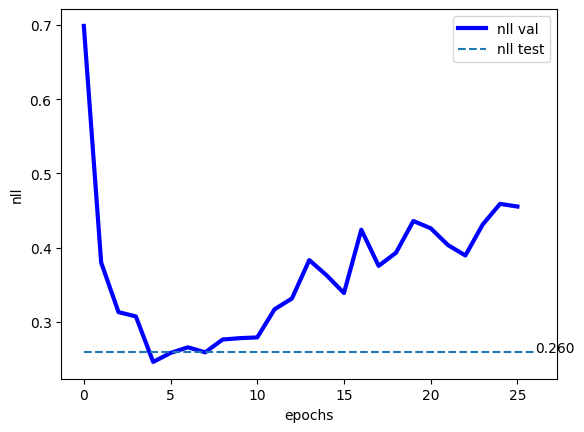

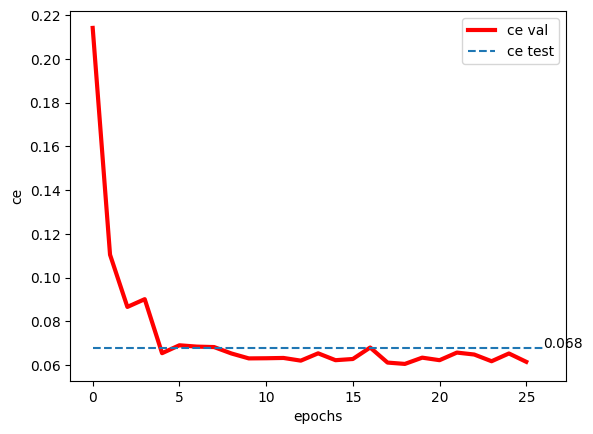

In [58]:
# initialize the model
model = MyNetwork()

# run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('The model runs on: ', device)
model.to(device)

# updata the dataloaders to run on the same device with the model 
training_loader = WrappedDataLoaderCustomize(training_loader, device)
val_loader= WrappedDataLoaderCustomize(val_loader,  device)
test_loader = WrappedDataLoaderCustomize(test_loader,  device)

# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad == True],
    lr=lr,
    weight_decay=wd,
)
# names:
result_dir = "/content/gdrive/MyDrive/CI"
name = 'MyNetwork'
# Training procedure
nll_val, error_val = training_mynetwork(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader,
)

# The final evaluation (on the test set)
test_loss, test_error = evaluation_mynetwork(name=result_dir + name, test_loader=test_loader)
# write the results to a file
f = open(result_dir + name + "_test_loss.txt", "w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()
# create curves
plot_curve(
    result_dir + name,
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    result_dir + name,
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)

### 3.4 Architecture with Extra Component

In [61]:
class MyNetworkWithaTwist(MyNetwork):
    def __init__(self):
        ''' 
        This is the same network as above, but with a twist.
        First: I added a dropout layer after each max pooling layer.
        Second: I added batch normalization after each convolutional block.
        The reason for adding dropout is to prevent overfitting.
        The reason for adding batch normalization is to make the training faster.
        It inherits the conv blocks and log likelihood loss from MyNetwork.
        '''
        # conv blocks are inherited from MyNetwork
        super().__init__()
        # dropout layers
        self.dropout = nn.Dropout(p=0.2)
        # batch normalization layers to the end of each conv block
        self.batch_norm_1 = nn.BatchNorm2d(64)
        self.batch_norm_2 = nn.BatchNorm2d(128)
        self.batch_norm_3 = nn.BatchNorm2d(256)
        self.batch_norm_4 = nn.BatchNorm2d(256)
        # log likelihood loss are inherited from MyNetwork
    
    def forward(self, x, y, reduction='avg'):
        x = self.conv_block_1(x)
        x = self.batch_norm_1(x)
        x = self.max_pooling(x)
        x = self.dropout(x)
        x = self.conv_block_2(x)
        x = self.batch_norm_2(x)
        x = self.max_pooling(x)
        x = self.dropout(x)
        x = self.conv_block_3(x)
        x = self.batch_norm_3(x)
        x = self.max_pooling(x)
        x = self.dropout(x)
        x = self.conv_block_4(x)
        x = self.batch_norm_4(x)
        x = self.max_pooling(x)
        x = self.dropout(x)
        x = x.flatten(1)
        x = self.fc_block_classifier(x)

        # nll between log-softmax result and the target
        loss = self.nll(x, y)

        if reduction == "sum":
            return loss.sum()
        else:
            return loss.mean()


    def classify(self, x):
        # Calculate scores of log-softmax
        x = self.conv_block_1(x)
        x = self.batch_norm_1(x)
        x = self.max_pooling(x)
        x = self.dropout(x)
        x = self.conv_block_2(x)
        x = self.batch_norm_2(x)
        x = self.max_pooling(x)
        x = self.dropout(x)
        x = self.conv_block_3(x)
        x = self.batch_norm_3(x)
        x = self.max_pooling(x)
        x = self.dropout(x)
        x = self.conv_block_4(x)
        x = self.batch_norm_4(x)
        x = self.max_pooling(x)
        x = self.dropout(x)
        x = x.flatten(1)
        scores = self.fc_block_classifier(x)
        # Predict the label based on highest score
        y_pred = scores.argmax(dim=1)
        # Cast to long
        y_pred = y_pred.long()
        return y_pred
        


        

The model runs on:  cuda
Epoch: 0, val nll=0.3716004851807866, val ce=0.1094048594048594
Epoch: 2, val nll=0.2552181193424547, val ce=0.07295932295932296
Epoch: 4, val nll=0.21750434341812733, val ce=0.06115206115206115
Epoch: 6, val nll=0.20675027228326395, val ce=0.05303030303030303
Epoch: 8, val nll=0.20137383876693338, val ce=0.05384930384930385
Epoch: 10, val nll=0.2185057171269816, val ce=0.05036855036855037
Epoch: 12, val nll=0.22832191511332672, val ce=0.050505050505050504
Epoch: 14, val nll=0.23304265633773608, val ce=0.05002730002730003
Epoch: 16, val nll=0.2606351898317364, val ce=0.05548730548730549
Epoch: 18, val nll=0.25673510231890767, val ce=0.052484302484302484
Epoch: 20, val nll=0.2794550356612529, val ce=0.051597051597051594
Epoch: 22, val nll=0.27858830302704046, val ce=0.05303030303030303
Epoch: 24, val nll=0.28414761330673677, val ce=0.05111930111930112
Epoch: 26, val nll=0.28978493207736183, val ce=0.049754299754299756
Epoch: 28, val nll=0.3109785021478935, val c

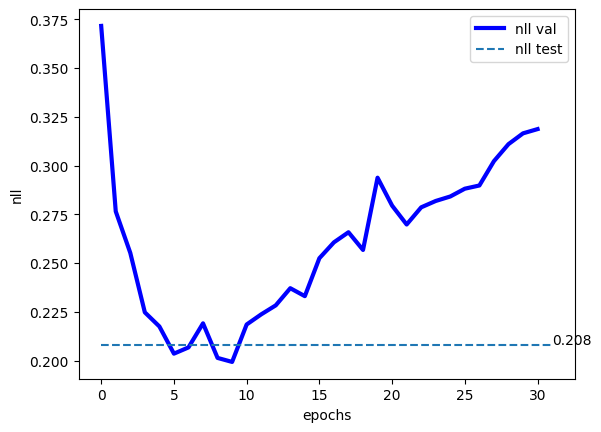

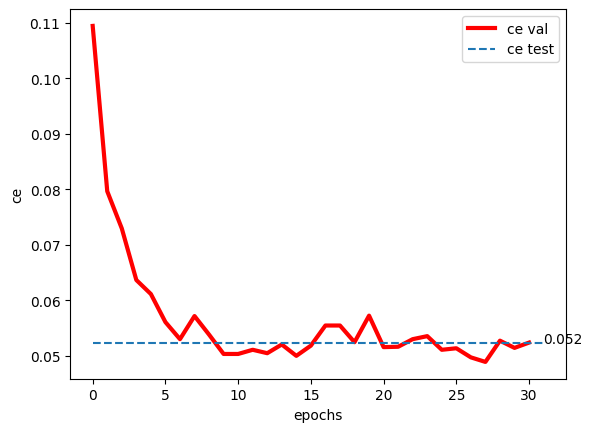

In [62]:
# initialize the model with a twist
model = MyNetworkWithaTwist()

# run on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('The model runs on: ', device)
model.to(device)

# updata the dataloaders to run on the same device with the model
training_loader = WrappedDataLoaderCustomize(training_loader, device)
val_loader= WrappedDataLoaderCustomize(val_loader,  device)
test_loader = WrappedDataLoaderCustomize(test_loader,  device)

# Init OPTIMIZER (here we use ADAMAX)
optimizer = torch.optim.Adamax(
    [p for p in model.parameters() if p.requires_grad == True],
    lr=lr,
    weight_decay=wd,
)
# names:
result_dir = "/content/gdrive/MyDrive/CI"
name = 'MyNetworkWithaTwist'
# Training procedure
nll_val, error_val = training_mynetwork(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader,
)

# The final evaluation (on the test set)
test_loss, test_error = evaluation_mynetwork(name=result_dir + name, test_loader=test_loader)
# write the results to a file
f = open(result_dir + name + "_test_loss.txt", "w")
f.write("NLL: " + str(test_loss) + "\nCE: " + str(test_error))
f.close()
# create curves
plot_curve(
    result_dir + name,
    nll_val,
    file_name="_nll_val_curve.pdf",
    ylabel="nll",
    test_eval=test_loss,
)
plot_curve(
    result_dir + name,
    error_val,
    file_name="_ca_val_curve.pdf",
    ylabel="ce",
    color="r-",
    test_eval=test_error,
)

### 3.5 Report

#### 3.5.1 Architecture and Components

As a base to my model proposition I used [VGG16](https://arxiv.org/pdf/1409.1556v6.pdf) architecture. In the following figure the details of the VGG16 can be seen. The reason for me to choose VGG16 as a base architecture is that it is a simple architecture that is easy to implement and understand. Moreover, it is a well known architecture that is used in many CV tasks and it is the winner of ImageNet 2014 competition. 

<img src="VGG16 Architecture Details.jpg" title="VGG" width="400"/>

Here, I only used 4 convolutional blocks and 3 fully connected layers. I did not use the last fully connected layer of VGG16. Instead, I used a fully connected layer with 10 neurons (number of classes). The reason for missing the last convolutional block is that by the end of the convolution 4 block we have done enough downsampling for the input images of size 32x32. Thus, I did not need to use the last convolutional block.

Convulational blocks consists of convolutional layers each followed by a ReLU activation function. Each convolutional block is followed by a max pooling layer that downsamples the input by 2. 

Also the sizes of last fully connected layers are adjusted to the fit our input and desired output of 10 classes.

I decided to use batch size of 32 to make it run faster to train. Other hyperparameters are same as the given ones in the assignment.

The table below shows the output sizes of the layers in the model.

| Layer | Output Size |
| --- | --- |
| Input | (32, 3, 32, 32) |
| Convolutional Block 1 | (32, 64, 32, 32) |
| Max Pooling 1 | (32, 64, 16, 16) |
| Convolutional Block 2 | (32, 128, 16, 16) |
| Max Pooling 2 | (32, 128, 8, 8) |
| Convolutional Block 3 | (32, 256, 8, 8) |
| Max Pooling 3 | (32, 256, 4, 4) |
| Convolutional Block 4 | (32, 256, 2, 2) |
| Max Pooling 4 | (32, 256, 1, 1) |
| Flatten | (32, 256) |
| Fully Connected 1 | (32, 256) |
| Fully Connected 2 | (32, 256) |
| Fully Connected 3 | (32, 10) |


For the extra component, I used dropout and batch normalization. Batch normalization follows the convolutional layers and dropout follows the max pooling layers. Batch normalization helps to normalize the input of the next layer. Dropout helps to prevent overfitting by randomly dropping some neurons. Again their shapes and parameters are adjusted to fit our input and output. 



#### 3.5.2 Result Analysis

**1. Loss Function:**

We can observe from the plots below that both models achieve a test loss less than 0.26. Initial model achieves 0.26 and the model with extra components achieves 0.208. This indicates that the model with extra components is better to detect probabilities compared to the initial model. Yet both models perform well on the test data. 

On the validation data, initial model achieves nll=0.246 on 4th epoch lowest and the model with extra components achieves nll=0.201 on 8th epoch lowest. For both of them we can see that they start to overfit or not improve on the validation data after a quite early epochs. 

However, the one with extra components starts to overfit later than the initial model. This can indicate that my aim to prevent overfitting with extra components of dropout and batch normalization is achieved. 

<img src="output_my_loss.png" title="CNN" width="400"/>
<img src="output_with_a_twist_loss.png" title="CNN" width="400"/>

**2. Classification Error:**

Pretty much same analysis can be done on the classification error as well. We can observe from the plots below that both models achieve a test error less than 0.07. Initial model achieves 0.068 and the model with extra components achieves 0.052 on test set. This indicates that the model with extra components is better to predict correct class compared to the initial model. Yet both models perform well on the test data and accomplish the task of classifying with less then 0.1 error. 

On the validation data, initial model achieves ce=0.062 on 12th epoch lowest and the model with extra components achieves ce=0.049 on 26th epoch lowest. For both of them we can see that they start to overfit or not improve on the validation data after a quite early epochs.

The other observations are same as above.

<img src="output_my_error.png" title="CNN" width="400"/>
<img src="output_with_a_twist_error.png" title="CNN" width="400"/>